In [1]:
%cd ..


/Users/eliaweiss/ai/segmentation/MobileSAM


In [2]:
import numpy as np
from tblDetect.TableDetect import TableDetect
from tblDetect.MobileSamBoxes import MobileSamBoxes
import matplotlib.pyplot as plt
from PIL import Image
from notebooks.Utils import plot_results, \
    plot_rotatedResult, \
        applyRotatedResult , \
        plot_annotations 
from tblDetect.AlignTable_Processor import AlignTable_Processor
from tblDetect.TblStructureDetect import TblStructureDetect

/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with tinyvit.tiny_vit.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: U

In [3]:
# init detectors
tblDec = TableDetect()
sam = MobileSamBoxes()
tblStructDetect = TblStructureDetect()       

checkpoint_load_scucess


In [4]:
file_list = ["/Users/eliaweiss/Documents/doc2txt/invoices 2/expense (6).jpeg", 
              "/Users/eliaweiss/Documents/doc2txt/sihach/attachments/img/20231025012642_001.jpg",
              "/Users/eliaweiss/Documents/doc2txt/sihach/need fix/4e7d4235deff4ee2b72d886e12ad0bcf.jpg"]

In [5]:
import os
folder = "/Users/eliaweiss/Documents/doc2txt/lineCv/1"
file_list = os.listdir(folder)
file_list = [file for file in file_list if 
             ".jpg" in file 
             or ".png" in file 
             or ".jpeg" in file]


In [6]:
fileIter = iter(file_list)
cc = 0

# align table

In [7]:
while True:
    file_path = next(fileIter)
    cc+=1    
    if cc < 18:
        continue
    print(cc)
    
    file_path = os.path.join(folder, file_path)
    print(file_path)

    img_pil = Image.open(file_path)
    # Resize the image
    img_pil.thumbnail((1500, 1500))
    # detect table
    probas, boxes = tblDec.detectTables(img_pil)
    if len(boxes):
        # find table mask
        anns = sam.process(img_pil,boxes)
    else:
        print("no tbl found!")
        anns = []
    

    tmpImg = np.array(img_pil)

    for ann in anns:
        alignTable_processor = AlignTable_Processor(img_pil, ann)
        tbl_patch_pil = alignTable_processor.getAlignTable()
        cells = tblStructDetect.detectTableStructure(tbl_patch_pil)
        rotated_cells =  alignTable_processor.unRotateAllCell(cells)
        applyRotatedResult(tmpImg, rotated_cells)
    
    # cv2.imshow("tmpImg",tmpImg)
    # cv2.waitKey()
    break

# pil_img = Image.fromarray(tmpImg)
# plt.figure(figsize=(16,10))
# plt.imshow(pil_img)
# plt.axis('off')
# plt.show() 

18
/Users/eliaweiss/Documents/doc2txt/lineCv/1/13.png
shape (1500, 1060, 3)
------ total time: (s): 2.02
self.hog_shape (153, 928)
self.main_shape (153, 928)
final lines: 1


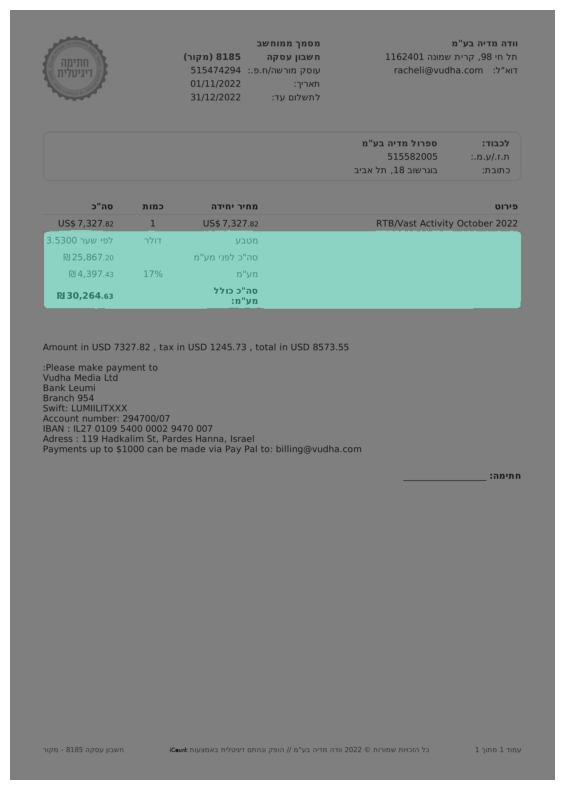

In [8]:
# def plot_annotations(img_pil, anns):
#     imgTmp = np.zeros((anns.shape[1], anns.shape[2], 3), dtype=np.uint8)
#     for ann in range(anns.shape[0]):
#         m = anns[ann].bool()
#         m=m.cpu().numpy()
#         color_mask = np.int0(np.random.random(3)*255)
#         imgTmp[m] = color_mask

#     background =  img_pil.convert("RGBA")
#     imgTmp = Image.fromarray(imgTmp).convert("RGBA")
#     pil_img = Image.blend(background, imgTmp, 0.5)            
#     plt.figure(figsize=(16,10))
#     plt.imshow(pil_img)
#     plt.axis('off')
#     plt.show() 

plot_annotations(img_pil, anns)    

     



In [9]:
color_mask


NameError: name 'color_mask' is not defined

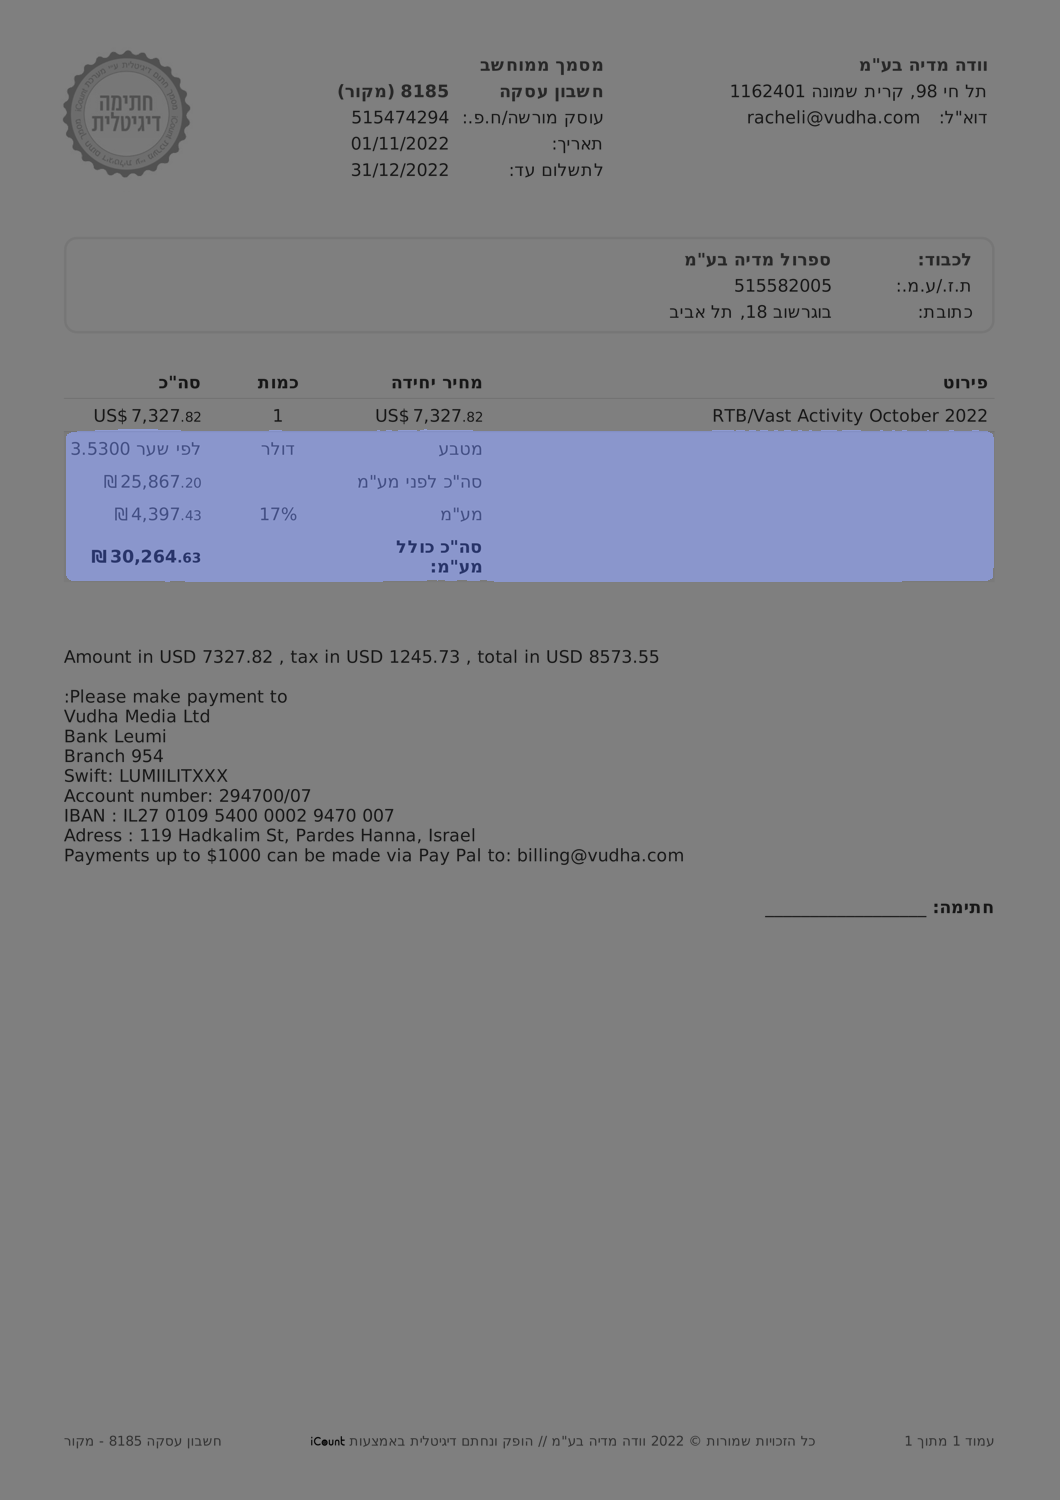

In [ ]:
imgTmp

In [ ]:
def applyLineSegment(mask, line, color=255):
    for i, ls in enumerate(line):
        left, bottom, right, top = ls.boundingBox
        if ls.patch is not None:
            for y in range(bottom, top):
                for x in range(left, right):
                    if ls.patch[y-bottom, x-left] > 0:
                        mask[y, x] = color
        elif ls.patch is None:
            mask[bottom:top, left:right] = color

116 <class 'lineVision.lineCv.line.LineCv_HogLine.LineCv_HogLine'>


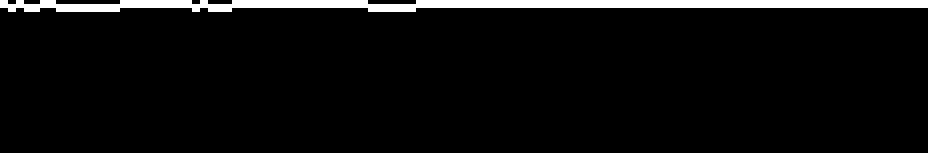

In [ ]:
mask = np.zeros(alignTable_processor.cvProcessor.imgZv.hog_shape, np.uint8)
for line in alignTable_processor.lines[:5]:
    print(len(line), type(line.parentLine))
    applyLineSegment(mask, line, color=(255))
    
Image.fromarray(mask)  

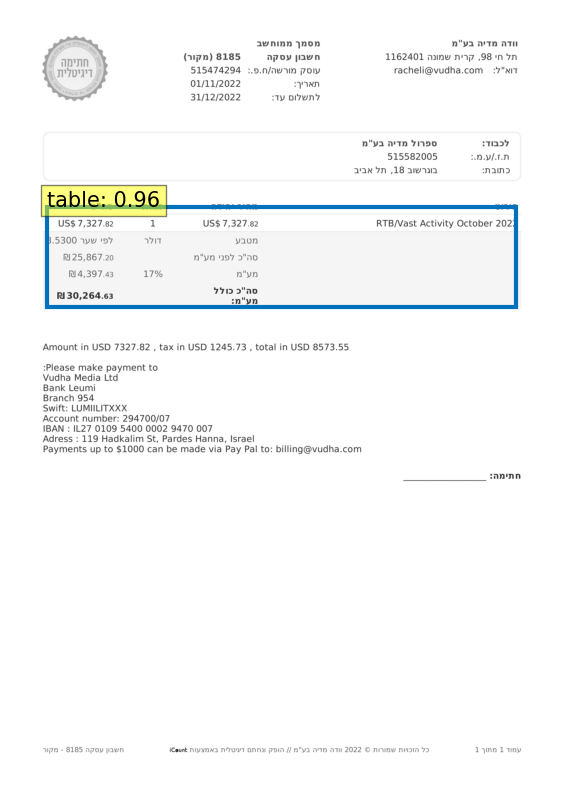

In [ ]:
# probas, boxes = tblDec.detectTables(img)

plot_results(tblDec.model, img_pil, probas, boxes)
